In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
sales= pd.read_csv('https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/catfish.csv', parse_dates= [0], index_col= 0, squeeze= True, date_parser= parser)

In [5]:
start_date= datetime(2000, 1, 1)
end_date= datetime(2004, 1, 1)
data= sales[start_date: end_date]

In [6]:
train_end= datetime(2003, 7, 1)
test_end= datetime(2004, 1, 1)

train_data= data[: train_end]
test_data= data[train_end+ timedelta(days= 1): test_end]

In [7]:
train_data.head()

Date
2000-01-01    25412
2000-02-01    25354
2000-03-01    29161
2000-04-01    24924
2000-05-01    24763
Name: Total, dtype: int64

In [8]:
print('Length of train data', len(train_data))
print('Length of test data', len(test_data))

Length of train data 43
Length of test data 6


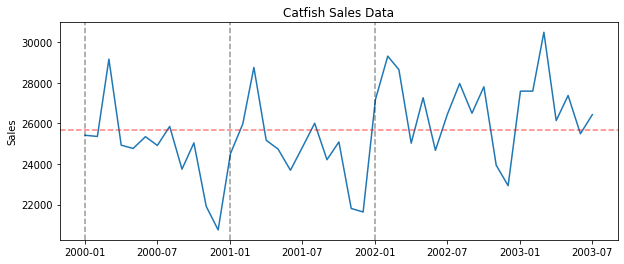

In [9]:
plt.figure(figsize= (10, 4))
plt.plot(train_data)
plt.title('Catfish Sales Data')
plt.ylabel('Sales')
for year in range(start_date.year, train_end.year):
    plt.axvline(pd.to_datetime(str(year)+ '-01-01'), color= 'k', linestyle= '--', alpha= 0.4)
plt.axhline(data.mean(), color= 'r', alpha= 0.5, linestyle= '--')

The data doesnt look stationary. seasonality is evident Check if it reuire any differencing.

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
print('P value of ADF Test:', adfuller(train_data)[1])# no differencing required

P value of ADF Test: 0.0003454906527934889


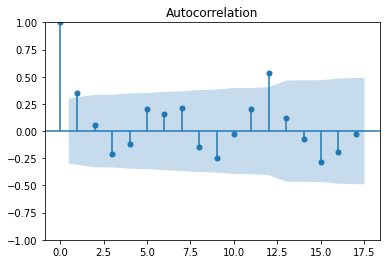

In [12]:
# ACF Plot 
plot_acf(train_data); # q is likely to be 1

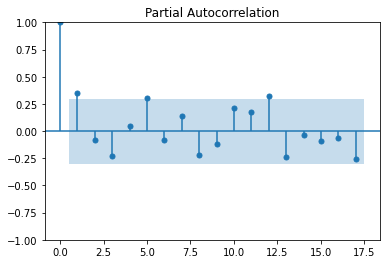

In [13]:
# PACF Plot
plot_pacf(train_data, method= 'ywm'); # P is likely to be 1

In [14]:
# Model ARMA(1,1)
model1= ARIMA(train_data, order= (1,0,1)).fit()
print(model1.summary())

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   43
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -387.300
Date:                Sat, 12 Feb 2022   AIC                            782.600
Time:                        10:50:22   BIC                            789.645
Sample:                    01-01-2000   HQIC                           785.198
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.563e+04    452.728     56.620      0.000    2.47e+04    2.65e+04
ar.L1          0.2620      0.438      0.598      0.550      -0.596       1.120
ma.L1          0.0981      0.455      0.215      0.8

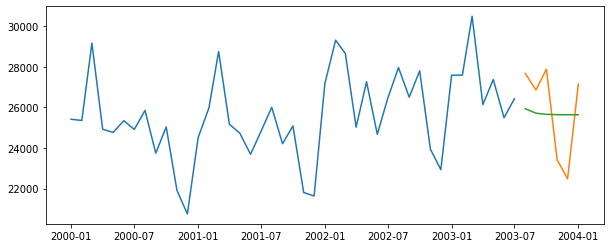

In [15]:
plt.figure(figsize= (10, 4))
plt.plot(train_data)
plt.plot(test_data)
plt.plot(model1.forecast(6))

The model is not good because we didnt take seasonality into consideration

In [16]:
# Taking seasonality into consideration
model2= SARIMAX(train_data, order= (1,0,1), seasonal_order= (1,0,1,12)).fit()
print(model2.summary())

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                   43
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -376.899
Date:                            Sat, 12 Feb 2022   AIC                            763.797
Time:                                    10:50:27   BIC                            772.603
Sample:                                01-01-2000   HQIC                           767.044
                                     - 07-01-2003                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   5.34e-06   1.87e+05      0.000       1.000       1.000
ma.L1         -0.8392      0.087   

C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


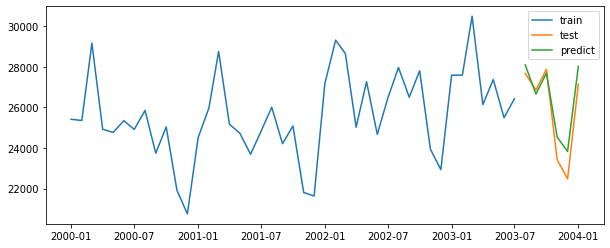

In [17]:
plt.figure(figsize= (10, 4))
plt.plot(train_data)
plt.plot(test_data)
plt.plot(model2.forecast(6))
plt.legend(['train', 'test', 'predict'])

This is a better model